# Exploración de datos

In [116]:
import sys
import os
from functools import reduce
import datetime

project_path = os.path.abspath('../..')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")

from src.utils import get_project_root
from src.data.make_dataset import get_minma_data

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Ventanas

### Carga de datos 

In [183]:
ventanas_df = get_minma_data(['SO2'], 'quintero', from_last='5y')
ventanas_df = ventanas_df.filter(regex='Registros no validados.*')
ventanas_df = ventanas_df.rename({'Registros no validados_SO2':'SO2'},axis=1)

/tmp/ipykernel_483/2406609855.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ventanas_df = get_minma_data(['SO2'], 'quintero', from_last='5y')


In [249]:
meteo_daily = [g.values for n, g in ventanas_df['SO2'].groupby(pd.Grouper(freq='D')) if ((not g.empty) & (g.values.shape[0] == 24))]

In [247]:
def get_dates_with(df, col, level, condition='leq'):
    if condition == 'leq':
        passed_limits = df.loc[df[col] < level]
    else:
        passed_limits = df.loc[df[col] > level]
    dates = np.unique(passed_limits.index.date)
    mask_to_drop = [date not in dates for date in df.index.date]
    return df.loc[mask_to_drop], dates

In [248]:
df, dropped_dates = get_dates_with(ventanas_df, 'SO2_ventanas', 130, 'geq')

KeyError: 'SO2_ventanas'

In [146]:
df

,SO2_ventanas
2017-09-06 18:00:00,2.76
2017-09-06 19:00:00,2.86
2017-09-06 20:00:00,3.17
2017-09-06 21:00:00,3.92
2017-09-06 22:00:00,12.87
...,...
2022-09-06 19:00:00,2.21
2022-09-06 20:00:00,2.25
2022-09-06 21:00:00,2.27
2022-09-06 22:00:00,2.30


<AxesSubplot:>

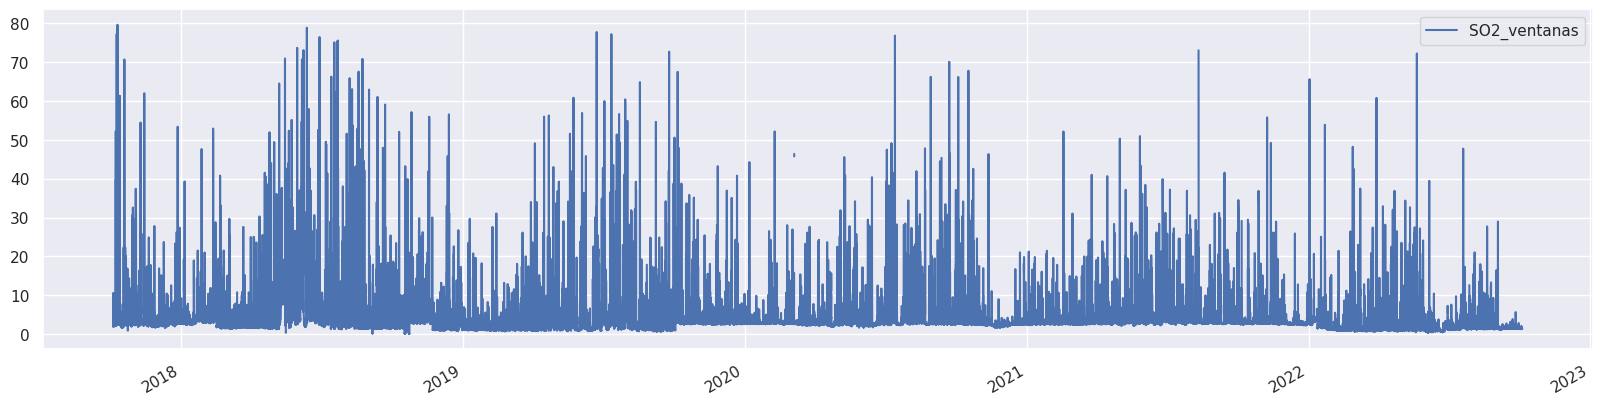

In [88]:
df.plot(figsize=(20,5))

In [250]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(24, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 24),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x.float())
        decoded = self.decoder(encoded)
        return decoded

In [251]:
class ADAutoEncoder(nn.Module):
    def __init__(self, kernel_size):
        super(ADAutoEncoder, self).__init__()

        self.Econv1 = nn.Conv1d(1, 32, kernel_size=kernel_size, stride=1)#, padding='same')
        self.dropout = nn.Dropout(0.2)
        self.Econv2 = nn.Conv1d(32, 16, kernel_size=kernel_size, stride=1)#, padding='same')
        self.Dconv1 = nn.ConvTranspose1d(16, 32, kernel_size=kernel_size, stride=1)#, padding='same')
        self.Dconv2 = nn.ConvTranspose1d(32, 1, kernel_size=kernel_size, stride=1)#, padding='same')
        # self.Dconv3 = nn.ConvTranspose1d(1, 1, kernel_size=7, stride=1)#, padding='same')

    def forward(self, x):
        x = nn.ReLU(self.Econv1(x))
        x = nn.ReLU(self.Econv2(x))
        x = nn.Dropout(x)
        x = nn.ReLU(self.Dconv1(x))
        x = nn.ReLU(self.Dconv2(x))
        # x = nn.ReLU(self.Dconv3(x))
        return x

In [252]:
class TSDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [261]:
model = AE()

In [262]:
dataset = TSDataset(meteo_daily)

In [263]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

loss_function = torch.nn.MSELoss()
 
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [280]:
losses = []

for epoch in range(100):
    for batch in dataloader:p
        reconstructed = model(batch)
        print(reconstructed)
        loss = loss_function(reconstructed, batch.float())
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        losses.append(loss)

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<SigmoidBackward0>)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<SigmoidBackward0>)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<SigmoidBackward0>)
tensor([[nan, nan, nan,  ..., nan, nan, nan],


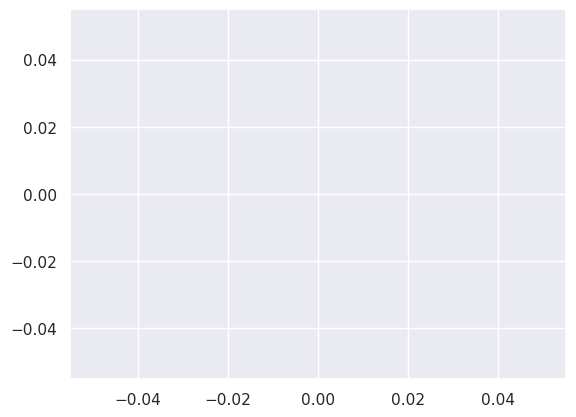

In [278]:
plt.plot(list(map(lambda x: x.detach(), losses)))

In [270]:
cems_df.set_index('date', inplace=True)

NameError: name 'cems_df' is not defined

In [99]:
qwe = pd.concat([ventanas_df,cems_df],axis=1).reset_index()

In [100]:
df = pd.merge(cems_df, ventanas_df, left_index=True, right_index=True).reset_index()

In [101]:
asd = df.melt(id_vars='index', value_vars=df.columns, var_name='planta')

In [102]:
zxc = qwe.melt(id_vars='index', value_vars=qwe.columns, var_name='planta')

In [77]:
# asd = asd.set_index('index')['2020':'2021']

In [106]:
asd.dropna(inplace=True)
zxc.dropna(inplace=True)


In [107]:
sns.set_context('talk')

Text(0.5, 1.0, 'Conteo de datos para distintos CEMS y \nSO2 Ventanas desde 2017 a 2022')

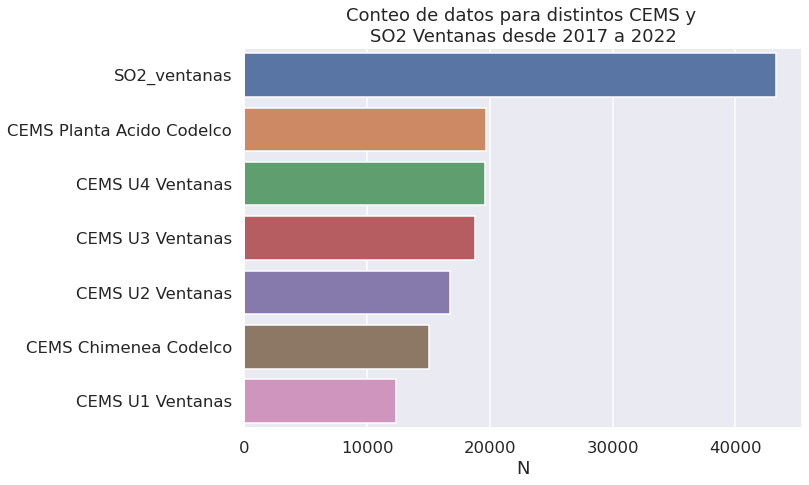

In [121]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(data=zxc, y='planta',ax=ax, order = zxc['planta'].value_counts().index)
ax.set_ylabel('')
ax.set_xlabel('N')
ax.set_title('Conteo de datos para distintos CEMS y \nSO2 Ventanas desde 2017 a 2022')

Text(0.5, 1.0, 'Conteo de datos para distintos CEMS y \nSO2 Ventanas desde 2020 a 2022')

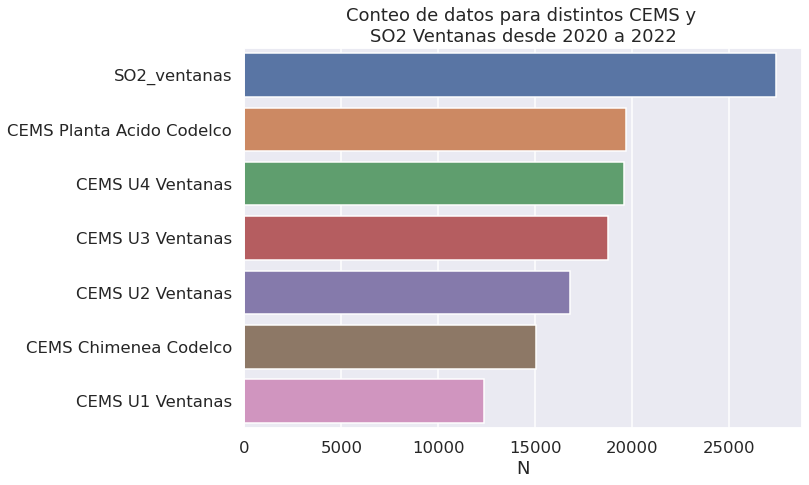

In [122]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(data=asd, y='planta',ax=ax, order = zxc['planta'].value_counts().index)
ax.set_ylabel('')
ax.set_xlabel('N')
ax.set_title('Conteo de datos para distintos CEMS y \nSO2 Ventanas desde 2020 a 2022')

### Visualización inicial

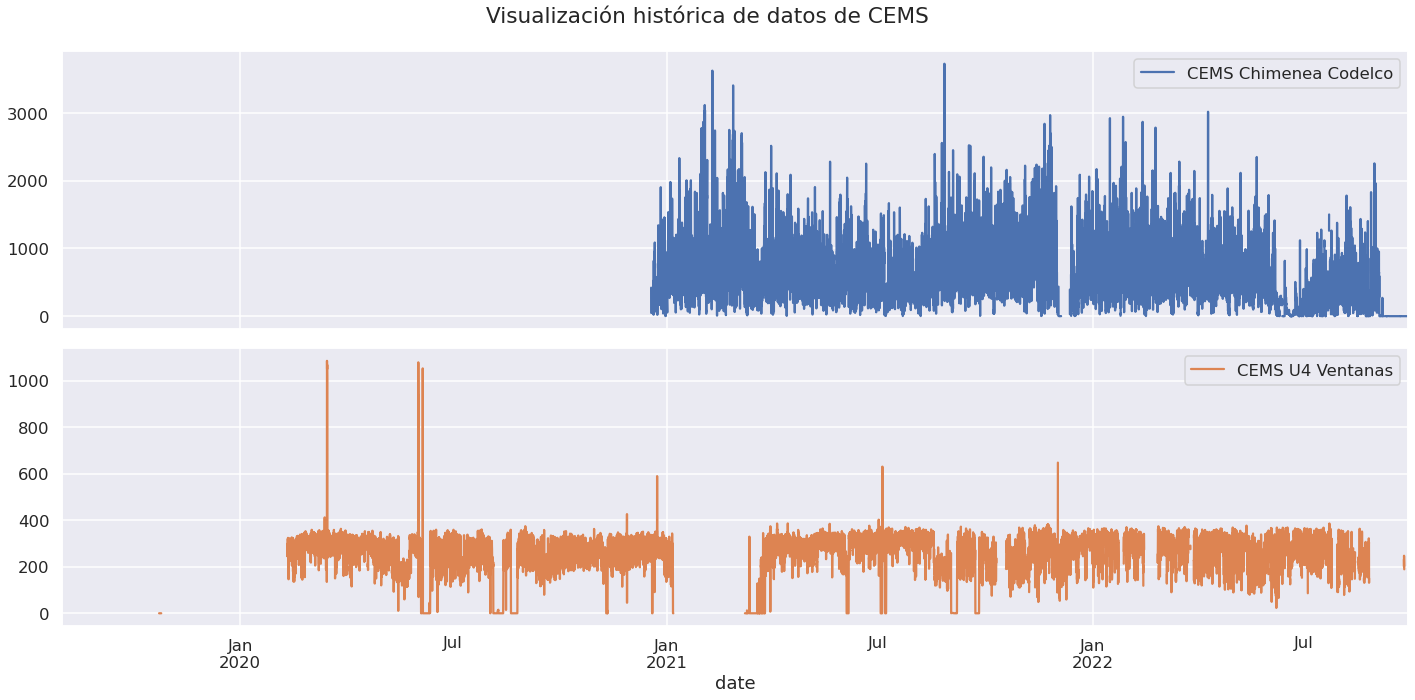

In [48]:
cems_df[['date','CEMS Chimenea Codelco',
 'CEMS U4 Ventanas']].set_index('date').plot(figsize=(20,10),subplots=True)
plt.suptitle('Visualización histórica de datos de CEMS')
plt.tight_layout()
plt.show()

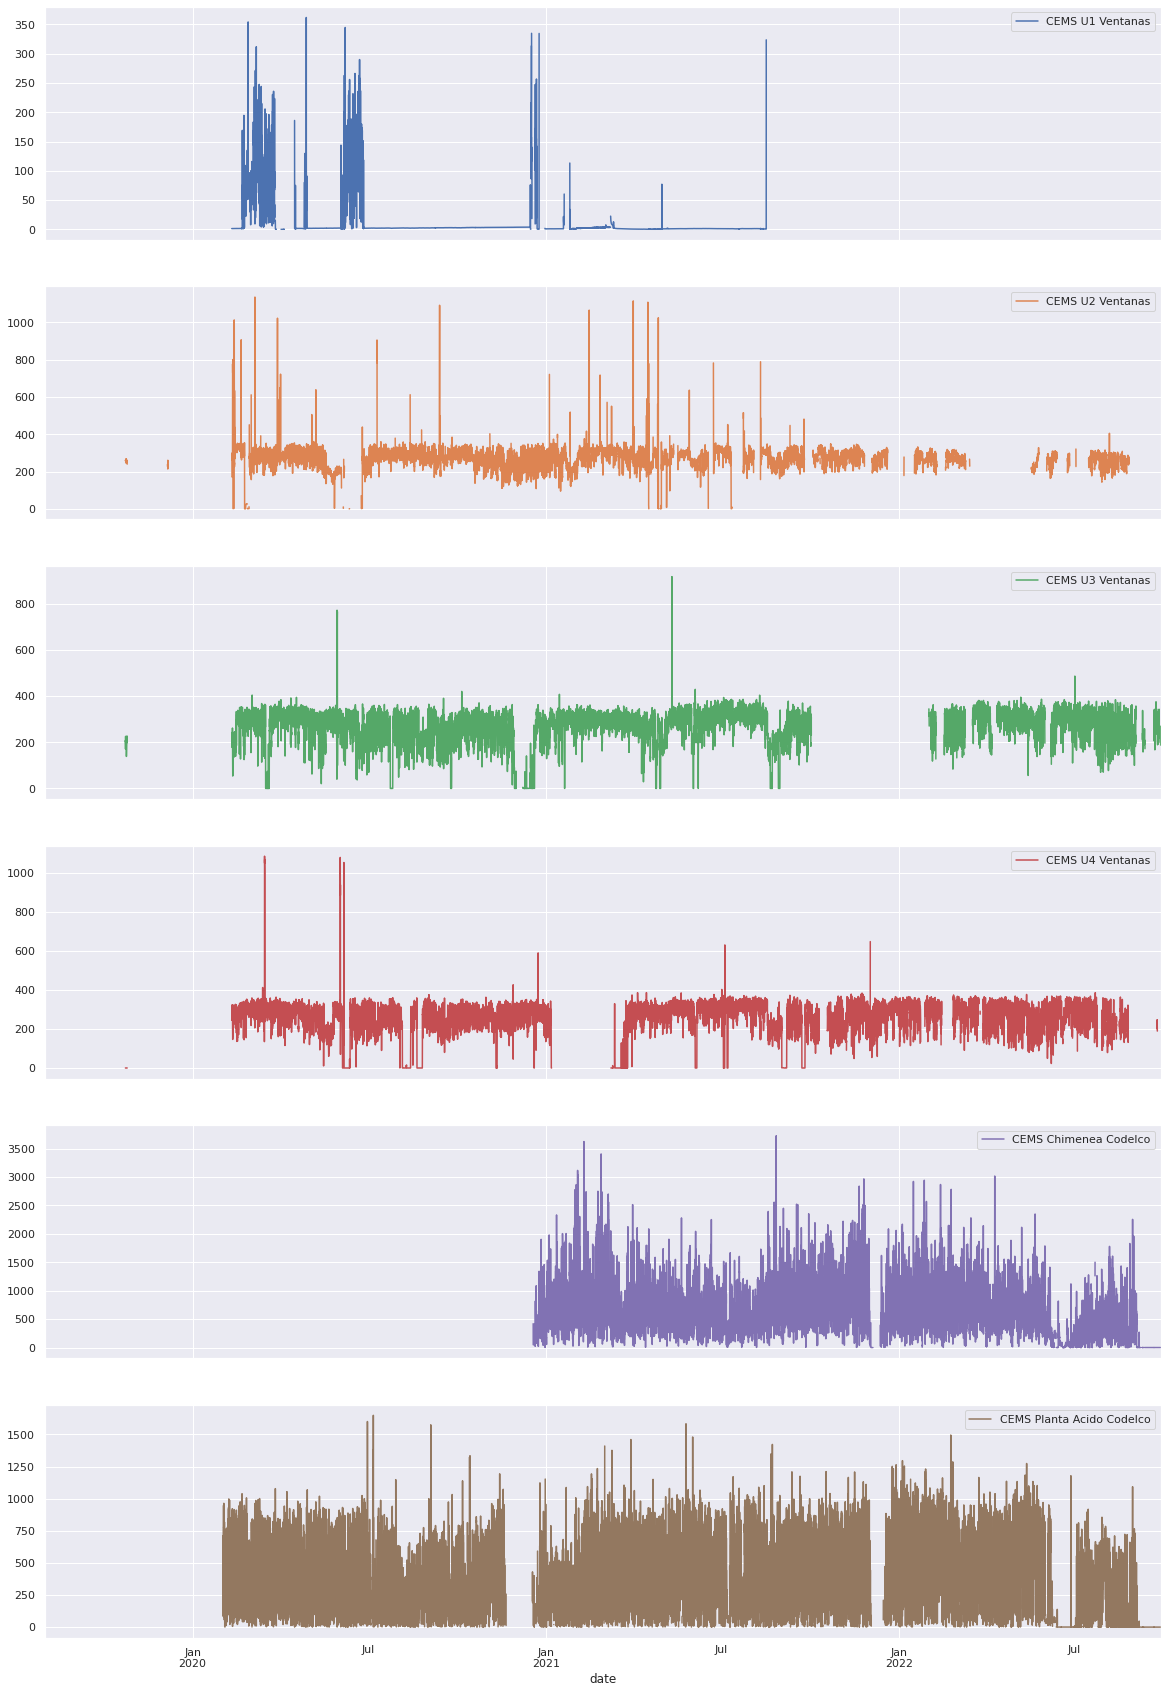

In [246]:
cems_df[['date','CEMS U1 Ventanas', 'CEMS U2 Ventanas', 'CEMS U3 Ventanas',
        'CEMS U4 Ventanas', 'CEMS Chimenea Codelco', 'CEMS Planta Acido Codelco']].set_index('date').plot(figsize=(20,30),subplots=True)
plt.show()

- CEMS U1 Ventanas con datos desde 10-02-2020 hasta 16-08-2021
- CEMS Chimenea Codelco con datos desde enero 2021

Omitir U1 Ventanas y solo ocupar la ventana de tiempo de la Chimenea Codelco? O al revés?

### Datos nulos

In [60]:
cems_df.isna().sum()

date                             0
CEMS U1 Ventanas             15323
CEMS U2 Ventanas             10925
CEMS U3 Ventanas              8951
CEMS U4 Ventanas              8125
CEMS Chimenea Codelco        12690
CEMS Planta Acido Codelco     8008
dtype: int64

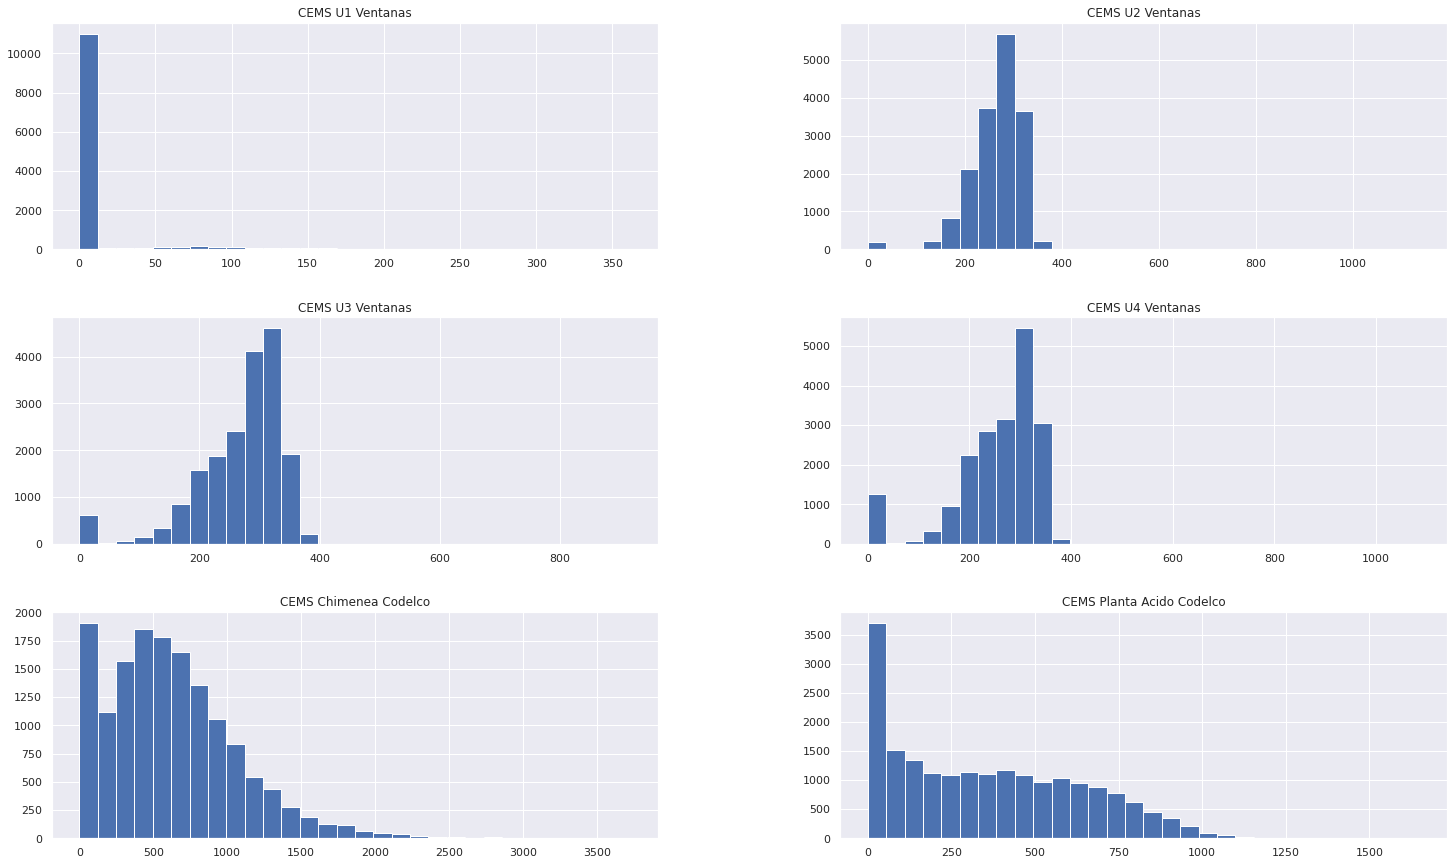

In [191]:
cems_df[['CEMS U1 Ventanas', 'CEMS U2 Ventanas', 'CEMS U3 Ventanas',
       'CEMS U4 Ventanas', 'CEMS Chimenea Codelco',
       'CEMS Planta Acido Codelco']].hist(figsize=(25,15), bins=30)
plt.show()

### Resumen estadístico

In [61]:
cems_df.describe()

,CEMS U1 Ventanas,CEMS U2 Ventanas,CEMS U3 Ventanas,CEMS U4 Ventanas,CEMS Chimenea Codelco,CEMS Planta Acido Codelco
count,12388.000000,16786.000000,18760.000000,19586.000000,15021.000000,19703.000000
mean,12.553066,266.664728,267.960240,254.333037,628.224463,359.028793
std,35.598075,62.860692,76.038918,89.209258,447.889732,282.253395
min,0.025691,0.072111,0.000000,0.000000,0.000000,0.000000
25%,1.071545,237.723750,231.588250,216.972250,310.120000,97.883150
50%,1.971170,274.011500,287.927500,279.314500,568.606000,327.583000
75%,3.053872,301.451000,318.527500,315.101500,874.874000,579.797000
max,361.922000,1136.140000,917.834000,1084.550000,3727.310000,1648.650000


### Cantidad de datos por fecha

In [193]:
cems_df['year'] = cems_df.date.apply(lambda x: x.year)
cems_df['month'] = cems_df.date.apply(lambda x: x.month)
cems_df['hour'] = cems_df.date.apply(lambda x: x.hour)

#### Anual

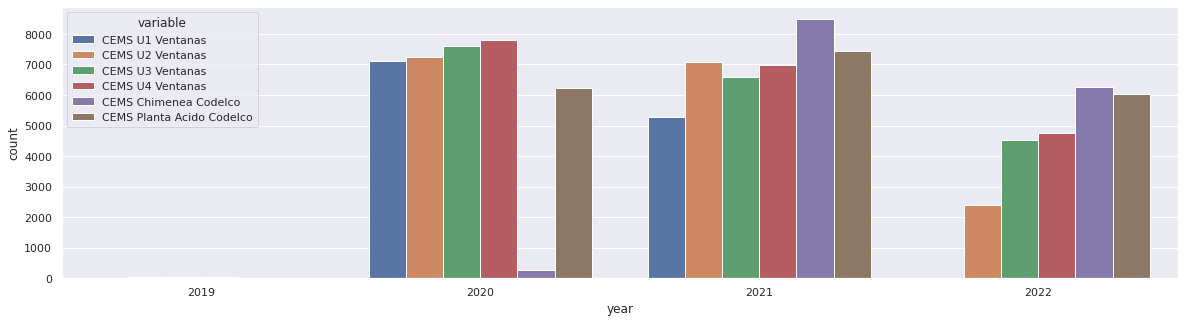

In [194]:
fig, ax = plt.subplots(figsize=(20,5))

sns.countplot(cems_df.melt(id_vars=['year', 'month','hour'], value_vars=cems_df.columns[1:-3]).dropna(), x='year', hue='variable', ax=ax)
plt.show()

#### Mensual

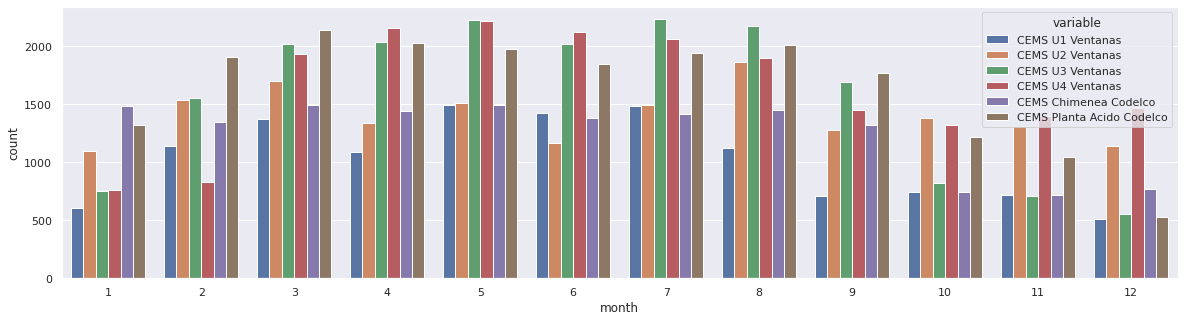

In [195]:
fig, ax = plt.subplots(figsize=(20,5))

sns.countplot(cems_df.melt(id_vars=['year', 'month','hour'], value_vars=cems_df.columns[1:-3]).dropna(), x='month', hue='variable', ax=ax)
plt.show()

#### Diario

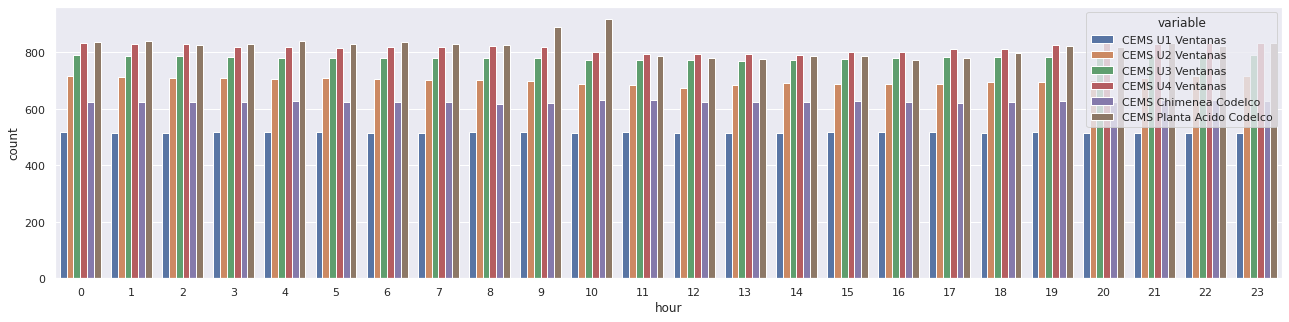

In [196]:
fig, ax = plt.subplots(figsize=(22,5))

sns.countplot(cems_df.melt(id_vars=['year', 'month','hour'], value_vars=cems_df.columns[1:-3]).dropna(), x='hour', hue='variable', ax=ax)
plt.show()

### Lag plots

#### 1 hora

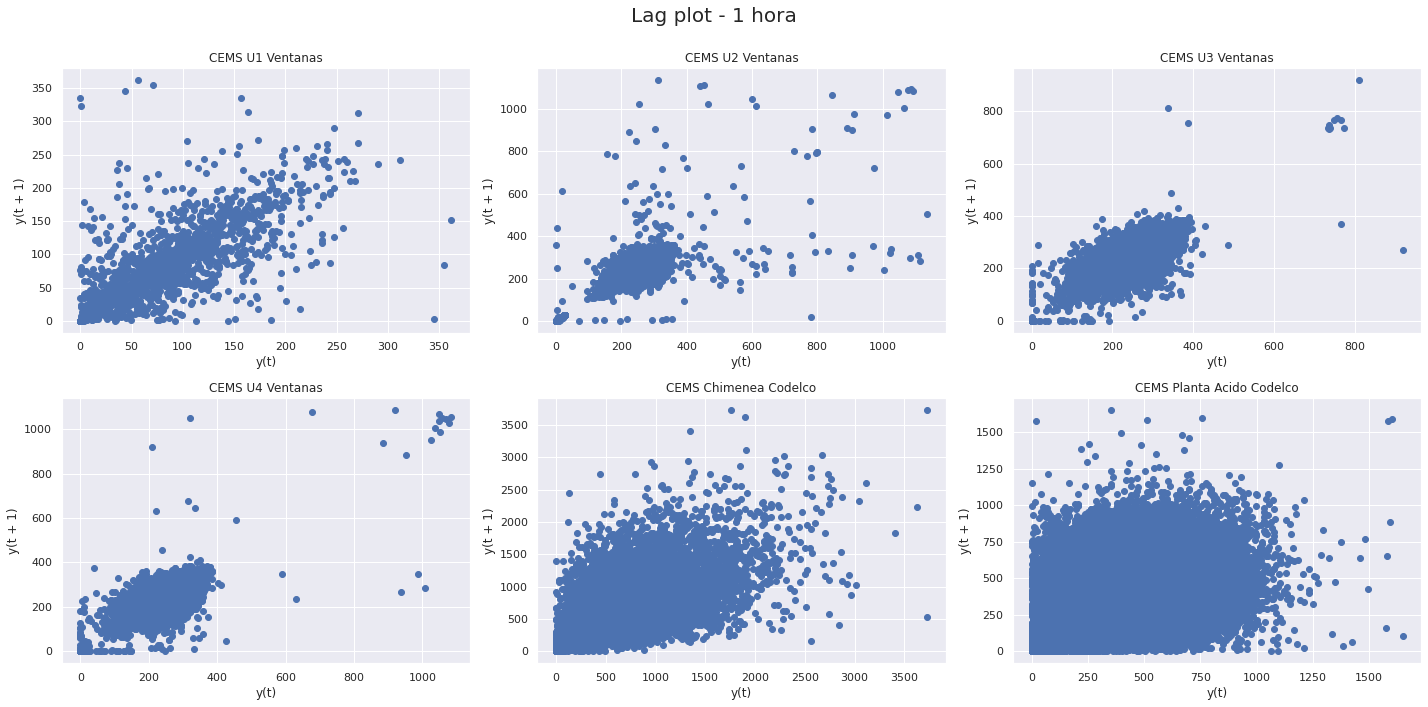

In [258]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

for idx, col in enumerate(['CEMS U1 Ventanas', 'CEMS U2 Ventanas', 'CEMS U3 Ventanas', 'CEMS U4 Ventanas', 'CEMS Chimenea Codelco', 'CEMS Planta Acido Codelco']):
    pd.plotting.lag_plot(cems_df[col], lag=1, ax=ax[idx//3, idx%3])
    ax[idx//3, idx%3].set_title(col)

fig.suptitle('Lag plot - 1 hora', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

#### 1 día

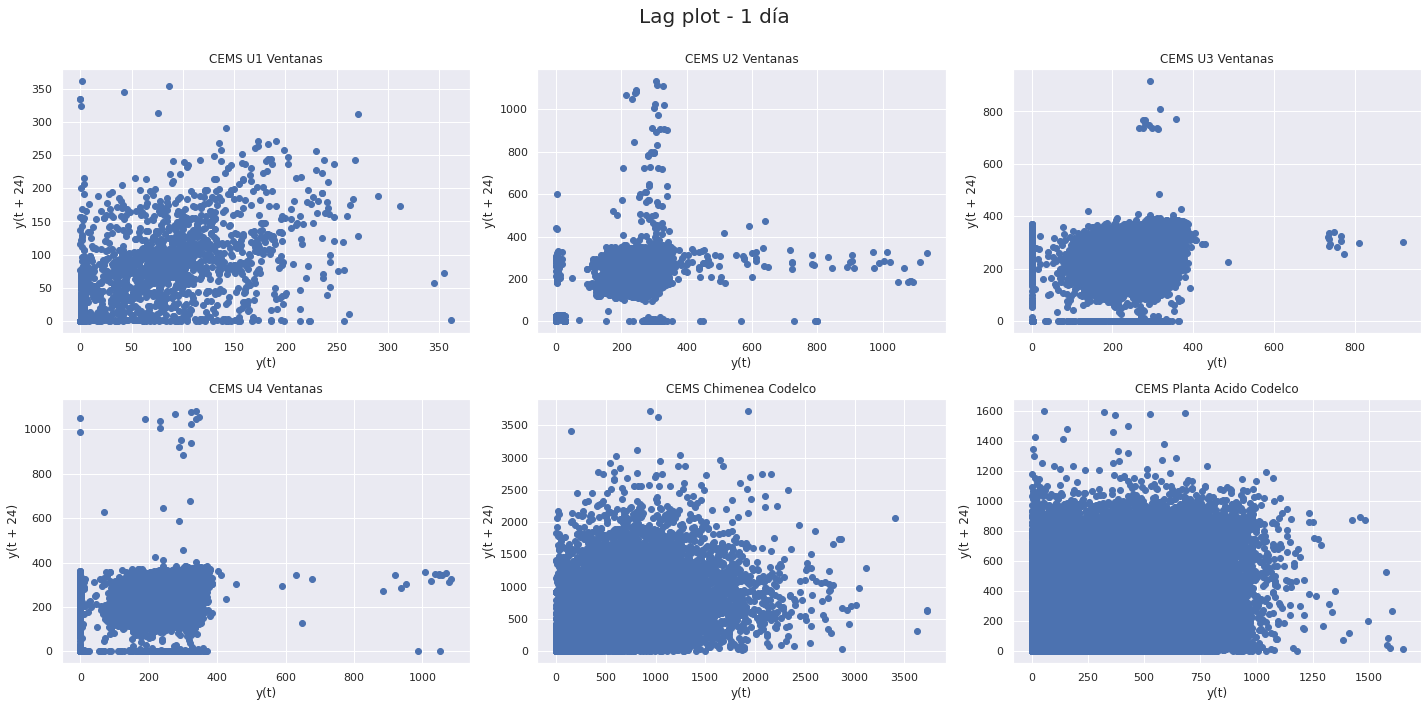

In [260]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

for idx, col in enumerate(['CEMS U1 Ventanas', 'CEMS U2 Ventanas', 'CEMS U3 Ventanas', 'CEMS U4 Ventanas', 'CEMS Chimenea Codelco', 'CEMS Planta Acido Codelco']):
    pd.plotting.lag_plot(cems_df[col], lag=24, ax=ax[idx//3, idx%3])
    ax[idx//3, idx%3].set_title(col)

fig.suptitle('Lag plot - 1 día', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

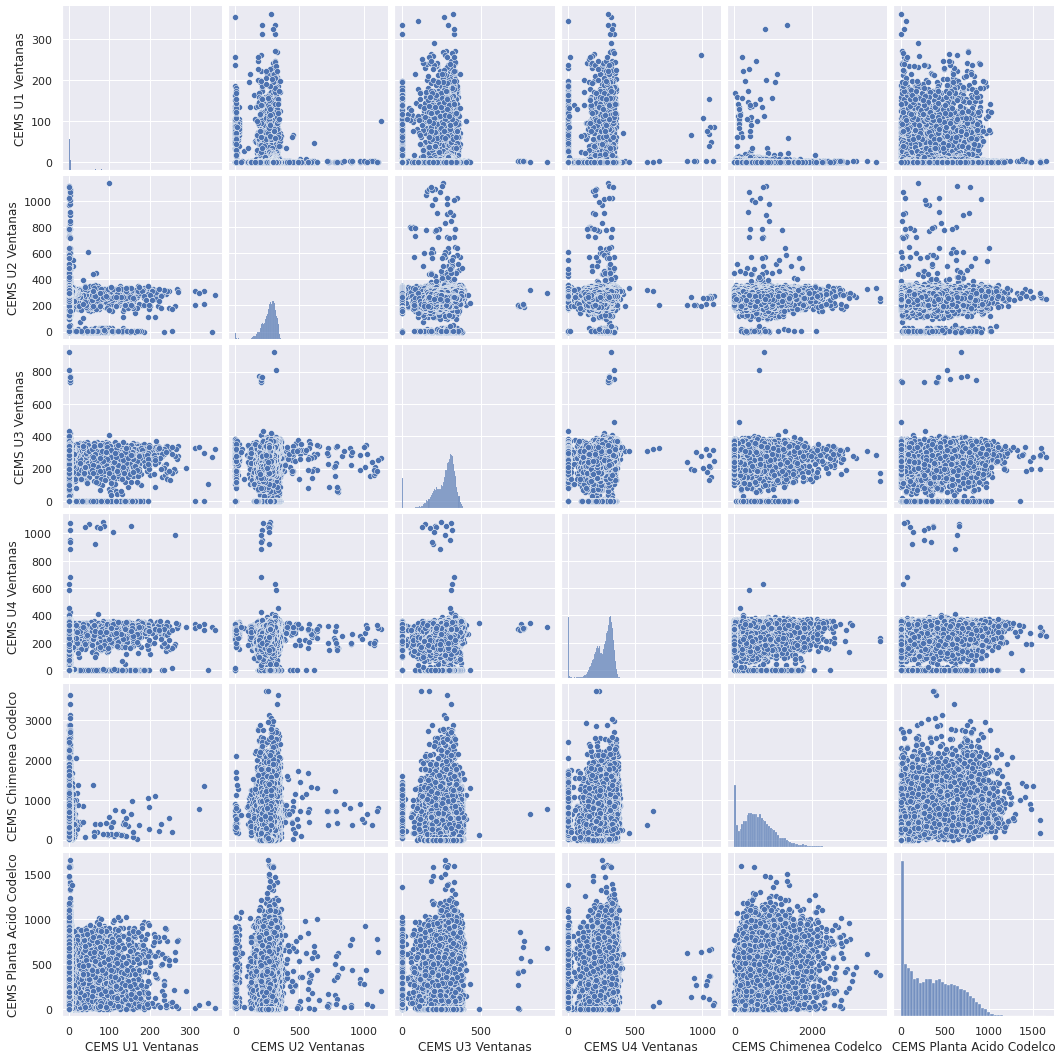

In [255]:
sns.pairplot(cems_df[['CEMS U1 Ventanas', 'CEMS U2 Ventanas', 'CEMS U3 Ventanas', 'CEMS U4 Ventanas', 'CEMS Chimenea Codelco', 'CEMS Planta Acido Codelco']])
plt.show()

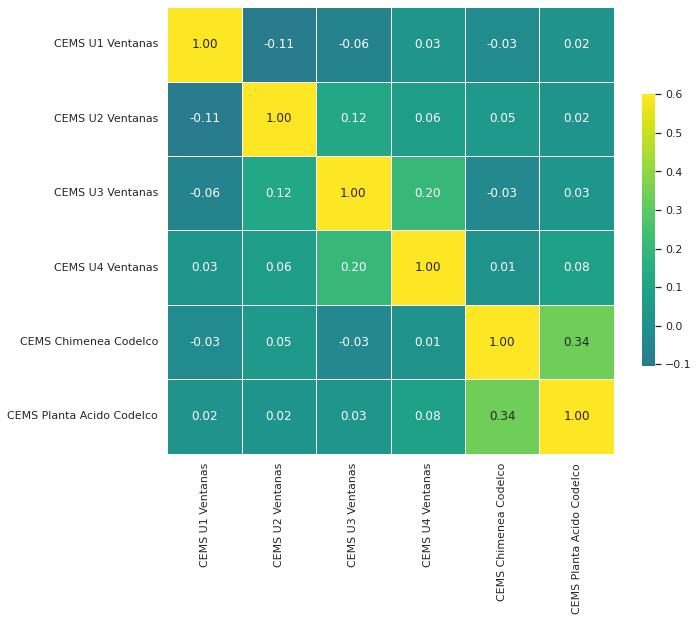

In [256]:
cems_corr = cems_df[['CEMS U1 Ventanas', 'CEMS U2 Ventanas', 'CEMS U3 Ventanas', 'CEMS U4 Ventanas',
                    'CEMS Chimenea Codelco', 'CEMS Planta Acido Codelco']].corr(method='pearson')

g = sns.heatmap(cems_corr,  vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='viridis')
g.figure.set_size_inches(10,10)
    
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

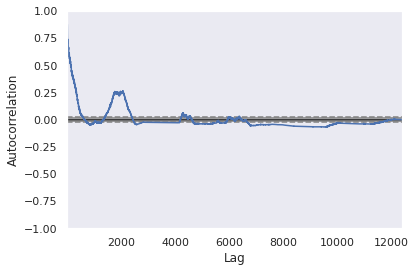

In [163]:
pd.plotting.autocorrelation_plot(cems_df['CEMS U1 Ventanas'].dropna())